# DeepSVDD

1) Supervised anomaly detection

- 데이터셋에 정상 / 비정상 라벨이 있는 경우

2) Semi-supervised anomaly detection

- 라벨이 안된 다량의 데이터와 소량의 정상 / 비정상 라벨이 있는 경우

- 정상 데이터만으로 학습

3) Unspervised anomaly detection

- 라벨이 아예 없는 경우

DeepSvdd → Semi-supervised 방식

In [ ]:
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1) One-Class SVM : mapping된 data를 잘 분리할 수 있도록 feature space에서 최대 마진의 초평면을 찾는 것.<br>
2) Support Vector Data Description(SVDD) : 정상 데이터가 구의 반지름 R과 중심점 c에 들어오도록 하는데 이때 가장 최소화되는 R를 찾는 것.<br>
3) Autoencoder : reconstruction error를 최소화하는 latent vector로 응축시켜 데이터를 일반화된 특성을 학습하여 이상치를 탐지.



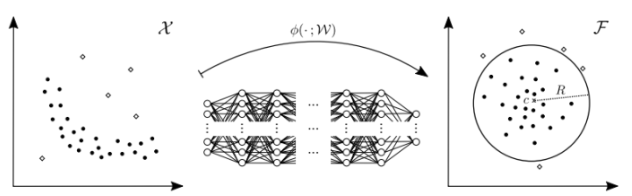

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/06/dsvdd.png')

Deep Learning을 기반으로 Normal Data를 둘러싸는 가장 작은 초구를 찾아 해당 경계면을 기반으로 이상을 탐지하는 방법

- 머신러닝 기반의 이상 탐지 알고리즘 SVDD를 Deep Learning으로 확장시킨 방법
- SVDD란, 머신러닝 알고리즘 SVM을 이상 탐지에 확장시킨 방법


- Input Space에서 Output Space로 변형시키는 Neural Network Transformation을 학습
    - SVDD에서 Kernel function을 사용했던 것을 Neural Network로 확장
- Output Space의 Representation vector를 둘러싸는 Hypersphere의 영역을 최소화
- Data point를 원 중심에 밀접하게 매핑해야 하기 때문에 Network는 공통 변동 요인을 추출

---------------------------------------------------------------------------

1. Soft-Boundary Deep SVDD
    - Train Data에 Abnormal Data가 존재한다고 가정
    - Train Data에 Hypersphere를 벗어나는 Data가 있다고 가정
    
    
2. One-Class Deep SVDD
    - Train Data가 모두 Normal Data라고 가정
    - 이 방법을 주로 사용

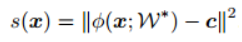

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/06/loss.png')

→ Neural Nework를 통해 representation한 data point들이 초구의 중심점과의 거리가 최소가 되도록 이것 자체가 Loss

Anomaly Score
- Output Space에서의 주어진 데이터와 초구 중심 사이의 거리 기반으로 측정
- 즉, 초구의 중심에서 멀수록 이상일 확률 높다고 가정

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import easydict

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from keras import datasets, layers, models, losses
import tensorflow_addons as tfa

from PIL import Image
from sklearn.metrics import roc_auc_score

* Data Preprocessing

In [ ]:
def global_contrast_normalization(x):
    
    mean = np.mean(x)
    x -= mean
    # 평균을 빼고
    x_scale = np.mean(np.abs(x))
    # 절대값의 평균
    x /= x_scale
    # 절대값의 평균으로 나누기
    return x

In [ ]:
def get_cifar10(args, data_dir='cifar10'):
    
    min_max = [(-28.94083453598571, 13.802961825439636),
               (-6.681770233365245, 9.158067708230273),
               (-34.924463588638204, 14.419298165027628),
               (-10.599172931391799, 11.093187820377565),
               (-11.945022995801637, 10.628045447867583),
               (-9.691969487694928, 8.948326776180823),
               (-9.174940012342555, 13.847014686472365),
               (-6.876682005899029, 12.282371383343161),
               (-15.603507135507172, 15.2464923804279),
               (-6.132882973622672, 8.046098172351265)]

    # GCN 이후 Class 별 Train Data의 min과 max 값 (미리 계산된 값)

    
    cifar10 = datasets.cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    x_train=global_contrast_normalization(np.float64(x_train))
    x_test=global_contrast_normalization(np.float64(x_test))
    # 위에서 구현한 함수적용
    
    normalizor = tf.keras.layers.Normalization(mean=[min_max[3][0]] * 3, variance=[min_max[3][1] - min_max[3][0]] * 3)
    x_train = normalizor(x_train)
    x_test = normalizor(x_test)
    # 논문에서 사용한 전처리: GCN과 Min-Max scaling 적용

    x_train = np.array([x_train[i] for i in np.where(y_train == args.normal_class)[0]])
    # 정상 데이터만 포함
    y_train = y_train[np.where(y_train == args.normal_class)]
    # 정상 데이터만 포함 : normal class 입력

    y_test = np.where(y_test == args.normal_class, 0, 1)
    # test는 정상은 0, 비정상은 1

    return (x_train, y_train), (x_test, y_test)

In [ ]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
# Pretrain 하지 않았을 경우 가중치 초기화

* Modeling

#### LeNet 구조의 AutoEncoder
- DeepSVDD의 초기 weights 값을 얻기 위해 DCAE를 활용해 Pretrain

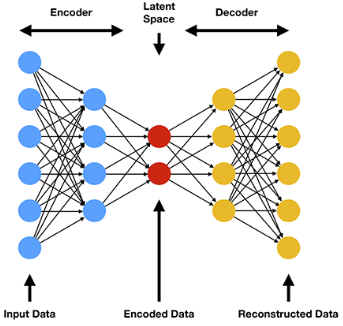

In [ ]:
Image.open('/content/drive/MyDrive/CDS2(2022-2)/img/02/ae.png')

In [ ]:
# CIFAR10_LeNet_Autoencoder
# 초기 LeNet 구조로 실험 더 좋은 net으로 업그레이드 가능.
class CIFAR10_LeNet_Autoencoder(tf.keras.Model):

  def __init__(self, rep_dim=128):
    super().__init__()
    self.rep_dim=rep_dim
    self.pool = layers.MaxPooling2D()
    self.leaky_relu = layers.LeakyReLU()

    self.bn2d1 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False) 
    self.bn2d2 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)
    self.bn2d3 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)
    self.bn2d4 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)
    self.bn2d5 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)
    self.bn2d6 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)
    self.bn1d = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)

    self.conv1 = layers.Conv2D(32, 5, use_bias=False, padding='same')
    self.conv2 = layers.Conv2D(64, 5, use_bias=False, padding='same')
    self.conv3 = layers.Conv2D(128, 5, use_bias=False, padding='same')
    self.fc1 = tf.keras.layers.Dense(self.rep_dim,  use_bias=False)

    self.deconv1 = layers.Conv2DTranspose(128, 5, use_bias=False, padding='same')
    self.deconv2 = layers.Conv2DTranspose(64, 5, use_bias=False, padding='same')
    self.deconv3 = layers.Conv2DTranspose(32, 5, use_bias=False, padding='same')
    self.deconv4 = layers.Conv2DTranspose(3, 5, use_bias=False, padding='same')
    
  def encoder(self, x):
      
    x = self.conv1(x)
    x = self.pool(self.leaky_relu(self.bn2d1(x)))
    x = self.conv2(x)
    x = self.pool(self.leaky_relu(self.bn2d2(x)))
    x = self.conv3(x)
    x = self.pool(self.leaky_relu(self.bn2d3(x)))
    x = layers.Flatten()(x)
    # Conv → BN → Pool X 3
    
    return self.fc1(x)


  def decoder(self, x):
    
    x = tf.reshape(x,[-1, 4,4,int(self.rep_dim / (4 * 4))])
    x = self.leaky_relu(x)
    x = self.deconv1(x)
    x = layers.UpSampling2D()(self.leaky_relu(self.bn2d4(x)))
    x = self.deconv2(x)
    x = layers.UpSampling2D()(self.leaky_relu(self.bn2d5(x)))
    x = self.deconv3(x)
    x = layers.UpSampling2D()(self.leaky_relu(self.bn2d6(x)))
    x = self.deconv4(x)
    # DEConv → BN → Pool X 3

    return tf.math.sigmoid(x)

  def call(self, inputs):
    z = self.encoder(inputs)
    z = self.bn1d(z)
    x_hat = self.decoder(z)
    
    return x_hat

- Input Space의 Raw Data를 Output Space(Hypersphere로 둘러싸인 공간)의 Representation vector로 잘 매핑시킬 수 있는 weight를 학습
- LeNet 구조 DCAE의 Encoder 구조와 동일한 구조로, 앞서 DCAE를 훈련하여 얻은 weights를 초기 weights로 사용

In [ ]:
#LeNet_CIFAR10_DeepSVDD
class LeNet_CIFAR10_DeepSVDD(tf.keras.Model):

  def __init__(self, rep_dim=128):
    super().__init__()
    self.rep_dim=rep_dim
    self.pool = layers.MaxPooling2D()
    self.bn2d1 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)
    self.bn2d2 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)
    self.bn2d3 = layers.BatchNormalization(epsilon=1e-04, scale=False, center=False)
    self.leaky_relu = layers.LeakyReLU()

    self.conv1 = layers.Conv2D(32, 5, use_bias=False, padding='same', kernel_initializer=initializer)
    self.conv2 = layers.Conv2D(64, 5, use_bias=False, padding='same', kernel_initializer=initializer)
    self.conv3 = layers.Conv2D(128, 5, use_bias=False, padding='same', kernel_initializer=initializer)
    self.fc1 = tf.keras.layers.Dense(self.rep_dim,  use_bias=False, kernel_initializer=initializer)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.pool(self.leaky_relu(self.bn2d1(x)))
    x = self.conv2(x)
    x = self.pool(self.leaky_relu(self.bn2d2(x)))
    x = self.conv3(x)
    x = self.pool(self.leaky_relu(self.bn2d3(x)))
    x = layers.Flatten()(x)
    # Conv → BN → Pool X 3 → flatten 128
    return self.fc1(x)

#### DeepSVDD Trainer

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
!mkdir weights_dsvdd

mkdir: cannot create directory ‘weights_dsvdd’: File exists


In [ ]:
class TrainerDeepSVDD:
    
    def __init__(self, args, x_train, y_train):
        
        self.args = args
        # 입력받을 인자
        self.x_train = x_train
        self.y_train = y_train
        
        
    def pretrain(self):
        
        ae = CIFAR10_LeNet_Autoencoder(self.args.latent_dim)
        # 위에서 정의한 Autoencoder 먼저 ae로 정의
        # 훈련하고 가중치를 초기값으로 사용
        ae.compile(
            optimizer=tfa.optimizers.AdamW(learning_rate=self.args.lr_ae,weight_decay=self.args.weight_decay_ae), 
            loss='mse'
        )
        # optimizer 정의
        # Optimizer that implements the Adam algorithm with weight decay.

        def scheduler(epoch, lr):
          if epoch < self.args.lr_milestones_ae[0]:
            return lr
            # 특정 값보다 작은 학습 단계에서는 유지하다가 이후 감쇠
          else:
            return lr * 0.1 # gamma=0.1
          # 스케줄러 : 학습하면서 동적으로 학습률 조정

        callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        # 스케줄러 학습시 적용하기 위해 callback에 담기

        history = ae.fit(self.x_train, self.x_train, # input과 output이 같음에 주의 -> auto encoder
                        batch_size=self.args.batch_size,
                        epochs=self.args.num_epochs_ae,
                        shuffle=True,
                        callbacks=[callback],
                        verbose=1)
                        # Auroencoder 학습

        self.save_weights_for_DeepSVDD(ae, self.x_train)
        # 학습한 모델 저장 : 바로 아래에 구현된 함수


    def init_center_c(self, model, x_train, eps=0.1):
        # 구의 중심점 초기화
        c=np.mean(model.encoder(x_train), axis=0)
        # c는 위에서 학습한 model의 encoder에 데이터를 입력한 값의 평균
        c[(abs(c) < eps) & (c < 0)] = -eps
        # c의 절대값이 엡실론보다 작고 c가 0보다 작으면 -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        # c의 값이 엡실로놉다 작고 c가 0보다 크면 eps
        return c
        # 스케일링 과정으로 이해
        

    def save_weights_for_DeepSVDD(self, model, x_train):
        
        c = self.init_center_c(model, x_train)
        # 구의 중심점 지정
        np.save('Latent_value', c)
        model.save_weights('pretrained_parameters')
        # model에 사전에 학습된 가중치로 입력

    # deepsvdd 학습
    def train(self):
        
        net = LeNet_CIFAR10_DeepSVDD()
        # deepsvdd 모델 정의

        if self.args.pretrain == True:
            pre_m = CIFAR10_LeNet_Autoencoder()
            pre_m.load_weights('pretrained_parameters')
            # 사전에 학습한 가중치 입력
            net.set_weights(pre_m.get_weights())
            c = np.load('Latent_value.npy')
            # 사전에 학습한 모델로 가중치와 중심점 가져오기
            
        else:
            c = np.random.randn(self.args.latent_dim)
            # 사전에 학습한 것을 사용하지 않으려면 중심점 랜덤하게 지정

        def set_loss(y, pred):
          return tf.math.reduce_mean(tf.math.reduce_sum((pred - c) ** 2, axis=1))
          # 위에서 정의한 loss

        net.compile(
            optimizer=tfa.optimizers.AdamW(learning_rate=self.args.lr,weight_decay=self.args.weight_decay), # Optimizer that implements the Adam algorithm with weight decay.
            loss=set_loss
        )
        # optimizer 정의

        def scheduler(epoch, lr):
          if epoch < self.args.lr_milestones[0]:
            return lr
          else:
            return lr * 0.1

        sch = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
        history = net.fit(self.x_train, np.array([c]*len(x_train)), # output 차원(,128)을 맞춰주기위해 임의의 데이터 생성
                        batch_size=self.args.batch_size,
                        epochs=self.args.num_epochs,
                        shuffle=True,
                        callbacks=[sch],
                        verbose=1)
                        # 학습
            
        self.net = net
        self.c = c
        
        return self.net, self.c
        # net과 c를 출력

In [ ]:
args = easydict.EasyDict({'num_epochs': 250,
                          'num_epochs_ae': 350,
                          'lr': 0.0001,
                          'lr_ae': 0.0001,
                          'weight_decay': 1e-6,
                          'weight_decay_ae': 1e-6,
                          'lr_milestones': [150],
                          'lr_milestones_ae': [250],
                          'batch_size': 200,
                          'pretrain': True,
                          'latent_dim': 128,
                          'normal_class': 8
                         })
# 인자를 지정

In [ ]:
(x_train, y_train), (x_test, y_test) = get_cifar10(args)

In [ ]:
deep_SVDD = TrainerDeepSVDD(args, x_train, y_train)

In [ ]:
deep_SVDD.pretrain()
# ae먼저 학습

Epoch 1/350
25/25 [==============================] - 12s 18ms/step - loss: 2.9807 - lr: 1.0000e-04
Epoch 2/350
25/25 [==============================] - 0s 18ms/step - loss: 2.5653 - lr: 1.0000e-04
Epoch 3/350
25/25 [==============================] - 0s 18ms/step - loss: 2.3399 - lr: 1.0000e-04
Epoch 4/350
25/25 [==============================] - 0s 18ms/step - loss: 2.1919 - lr: 1.0000e-04
Epoch 5/350
25/25 [==============================] - 0s 18ms/step - loss: 2.0874 - lr: 1.0000e-04
Epoch 6/350
25/25 [==============================] - 0s 18ms/step - loss: 2.0107 - lr: 1.0000e-04
Epoch 7/350
25/25 [==============================] - 0s 18ms/step - loss: 1.9591 - lr: 1.0000e-04
Epoch 8/350
25/25 [==============================] - 0s 19ms/step - loss: 1.9282 - lr: 1.0000e-04
Epoch 9/350
25/25 [==============================] - 0s 18ms/step - loss: 1.9082 - lr: 1.0000e-04
Epoch 10/350
25/25 [==============================] - 0s 18ms/step - loss: 1.8942 - lr: 1.0000e-04
Epoch 11/350
25/25

In [ ]:
net, c = deep_SVDD.train()

Epoch 1/250
25/25 [==============================] - 1s 9ms/step - loss: 68.4481 - lr: 1.0000e-04
Epoch 2/250
25/25 [==============================] - 0s 9ms/step - loss: 4.8130 - lr: 1.0000e-04
Epoch 3/250
25/25 [==============================] - 0s 9ms/step - loss: 2.0276 - lr: 1.0000e-04
Epoch 4/250
25/25 [==============================] - 0s 9ms/step - loss: 1.4007 - lr: 1.0000e-04
Epoch 5/250
25/25 [==============================] - 0s 9ms/step - loss: 1.0958 - lr: 1.0000e-04
Epoch 6/250
25/25 [==============================] - 0s 9ms/step - loss: 0.9018 - lr: 1.0000e-04
Epoch 7/250
25/25 [==============================] - 0s 9ms/step - loss: 0.7632 - lr: 1.0000e-04
Epoch 8/250
25/25 [==============================] - 0s 9ms/step - loss: 0.6603 - lr: 1.0000e-04
Epoch 9/250
25/25 [==============================] - 0s 9ms/step - loss: 0.5798 - lr: 1.0000e-04
Epoch 10/250
25/25 [==============================] - 0s 9ms/step - loss: 0.5161 - lr: 1.0000e-04
Epoch 11/250
25/25 [========

In [ ]:
pred=net.predict(x_test)

In [ ]:
scores=tf.math.reduce_sum((pred - c) ** 2, axis=1)

In [ ]:
len(y_test)

10000

In [ ]:
sum(y_test)

array([9000])

In [ ]:
print('ROC AUC score: {:.2f}'.format(roc_auc_score(y_test, scores) * 100))

ROC AUC score: 74.08
